In [2]:
import numpy as np
import torchvision
import torchvision.datasets as datasets
from sklearn.decomposition import PCA
import scipy.stats as stats
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

### Part I: Train GMM with no dataset argumentation ###

 In this document, we will experiment on using pretrained GMM to predict untrained labels. MNIST is the test dataset. <br> In stage 1 (pretrain), 10 - k random classes of numbers will be drawn from 10 digits and each of the classes will be fit by a GMM model. Then in stage 2 (unsupervised learning), each of the test data will be predict by all the pretrained GMM classifiers. If all the classifiers gives a score under some treshold (fixed), then all these unclassifed rows will be gathered together and fit with k extra classifiers.<br> The basic assumpition it each class of digits shares some features follows Gaussian distribution and we can use number of classes inside a GMM to fit with different writing styles or other variations.

Step 1: Load MNIST DataSet

In [8]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
mnist_trainset =  datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
raw_trainX = mnist_trainset.data.numpy()
raw_trainY = mnist_trainset.targets.numpy()
raw_testX = mnist_testset.data.numpy()
raw_testY = mnist_testset.targets.numpy()  

Step 2: Using Principal component analysis (PCA) to reduce the dimension which can boost both training time and acurracy.

In [9]:
# use pca to reduce the dimesion of the dataset, original data size is 28 * 28
pca = PCA(n_components=60)
trainX = raw_trainX.reshape(raw_trainX.shape[0], -1)
trainX = pca.fit_transform(trainX)
testX = raw_testX.reshape(raw_testX.shape[0], -1)
testX = pca.transform(testX)

Pretrained_GMM: 
###### feed in features-x and labels-y, automatically seperate images by their labels and use a GMM to fit for each classes. comp is the number of mixture components in each classifier. Class size defines how many images in each classes is feed in in the first stage. In MNIST, each classes has approximately 6000 samples. By constrainting how much samples to be feed in the first stage, we can test the performance of the models to recognize unseen images belonging to pretrained GMMs. ######

GMMs_predict:
###### It is used in stage 2, by passing the pretrained gmms from stage 1 and the whole dataset, the models predicts the score of how lilkely the image belonging to those 10 - k pretrained GMM. If the score samller than some threshold we mark the row as unclassifed (-1) and requires further classfication. <br> NOTE: We tried to first apply softmax to the scores and filter the prediction with confidence (e.x. 95%). However, this method works quite worse than a direct threshold on the scores. The reason could be a tiny difference in score will result in a large digit difference in confidence. There are also cases where every class has a small score but one of them dominates the confidence. A threshold apply directly on the scores reduces these problems.

GMM_classify:
###### This function is used to classify those images which cannot be predict with pretrained GMMs. Here we use a single GMM and set the number of mixture components as the number of rest of classes-k. We only need a roughly classification that can distinguish different number images. One alternative could be uses full GMM for each different class and apply EM algorithm to optimize the prediction. However, in practise this solution cost much more time and only a limited improvement was observed so we choose to stick with naive GMM implementation.

In [10]:
def pretrained_GMM(x, y, stage1_labels, comp=5, class_size=5000):
    model = []
    # stage 1 supervised learning
    for i in stage1_labels:
        trainX_i = x[y == i]
        model.append(GaussianMixture(n_components=comp).fit(trainX_i[:class_size]))
    return model

def GMMs_predict(x, gmms, k, threshold):
    predict = np.zeros((x.shape[0], k), dtype=float)
    # use pretrained model to predict x
    for i in range(k):
        predict[:,i] = gmms[i].score_samples(x)
    
    max_class = np.amax(predict, axis=1)
    return np.where(max_class > threshold, np.argmax(predict, axis=1), -1)

def GMM_classify(x, y, cnum):
    predict = GaussianMixture(n_components=cnum).fit_predict(x)
    result = []
    for i in range(cnum):
        label = stats.mode(y[predict == i])
        result.append((x[predict == i], label))
    return result

In [19]:
def GMM_solution(x, y, total_class, K, gmm_components=5):
    # stage 1 supervised training:
    stage1_classes = random.sample(range(total_class), K)                       # a random K-subset of [0,9]
    print(stage1_classes)
    stage1_model = pretrained_GMM(x, y, stage1_classes, gmm_components)

    # stage 2 unsupervised training:
    predict = GMMs_predict(x, stage1_model, K, -380)

    new_GMMs = []
    labels = []
    for i in range(K):
        new_GMMs.append(GaussianMixture(n_components=gmm_components).fit(x[predict == i]))
        labels.append(stats.mode(y[predict == i])[0])

    # use rows cannot be classified to train the rest classes
    if total_class > K:
        if total_class - K == 1:
            unlabel_predict = [(x[predict == -1], stats.mode(y[predict == -1])[0])]
        else:
            unlabel_predict = GMM_classify(x[predict == -1], y[predict == -1], 10 - K)

        for i in range(10 - K):
            data, label = unlabel_predict[i]
            new_GMMs.append(GaussianMixture(n_components=10).fit(data))
            labels.append(label[0])
    return new_GMMs, labels

def GMM_validation(gmms, labels, trainX, trainY, testX, testY, vali=False):
    ind_func = lambda x: labels[x]
    ind_func = np.vectorize(ind_func)

    total_class = len(labels)
    train_predict = GMMs_predict(trainX, gmms, total_class, -np.inf)
    train_predict = ind_func(train_predict)
    

    test_predict = GMMs_predict(testX, new_GMMs, total_class, -np.inf)
    test_predict = ind_func(test_predict)
    
    if vali:
        return np.sum(train_predict == trainY) / trainY.shape, np.sum(test_predict == testY) / testY.shape, test_predict
    else:
        return np.sum(train_predict == trainY) / trainY.shape, np.sum(test_predict == testY) / testY.shape

Step 3: First we test on feed in all the images, GMMS classifer could easily achieve a over 95% percent accuracy.

In [12]:
new_GMMs, labels = GMM_solution(trainX, raw_trainY, 10, 10)
train_accuracy, test_accuracy = GMM_validation(new_GMMs, labels, trainX, raw_trainY, testX, raw_testY)
print("GMM's Accuracy on training set: {0}".format(train_accuracy))
print("GMM's Accuracy on test set: {0}".format(test_accuracy))

GMM's Accuracy on training set: [0.96075]
GMM's Accuracy on test set: [0.9586]


In [16]:
def cal_heatMap(predictY, gtY):
    result = np.zeros((10,10), dtype=float)
    for i in range(10):
        idx = (gtY == i)
        idx_len = np.sum(idx)
        for j in range(10):
            class_pre = predictY[idx] == j
            result[i,j] = np.sum(class_pre) / idx_len
    return result        

Step 4: Now we attempt to reduce the class feed in as pretraining. Accuracy are shown below.

Pre feed classes 5
[8, 7, 1, 6, 0]


/home/kent/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Pre feed classes 6
[2, 7, 4, 0, 9, 6]


/home/kent/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Pre feed classes 7
[3, 9, 8, 1, 6, 7, 0]
Pre feed classes 8
[8, 7, 9, 0, 3, 4, 5, 6]
Pre feed classes 9
[1, 4, 0, 6, 8, 9, 7, 2, 3]


/tmp/ipykernel_1323/4041640475.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('212')


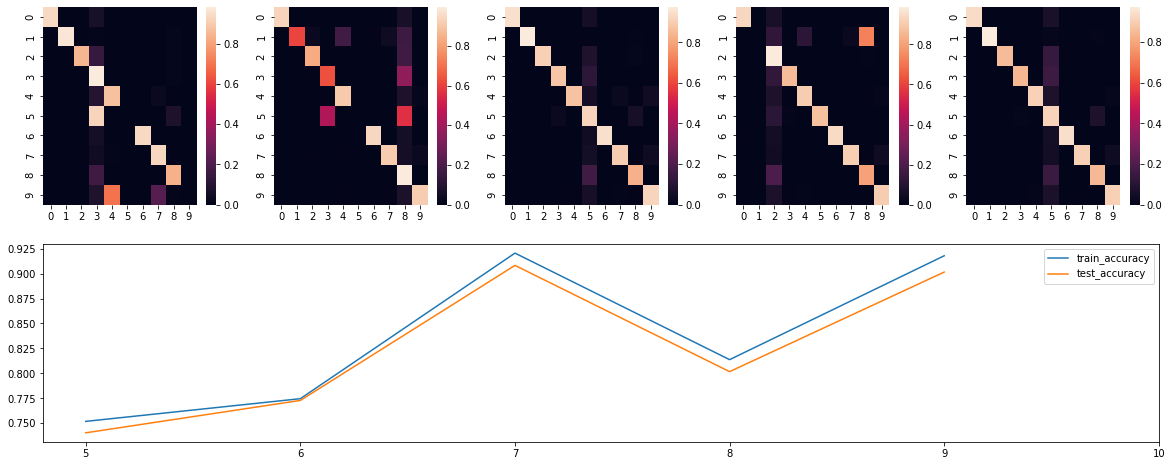

In [38]:
ks = [5,6,7,8,9]
train_accuracy = []
test_accuracy = []
plt.figure(figsize=(20, 8))
for k in ks:
    print('Pre feed classes {0}'.format(k))
    new_GMMs, labels = GMM_solution(trainX, raw_trainY, 10, k, 7)
    tra, tta, pred = GMM_validation(new_GMMs, labels, trainX, raw_trainY, testX, raw_testY, True)
    class_accuracy = cal_heatMap(pred, raw_testY)
    plt.subplot(250 + k - 4)
    sns.heatmap(class_accuracy)
    train_accuracy.append(tra)
    test_accuracy.append(tta)
plt.subplot('212')
plt.plot(ks, train_accuracy, label='train_accuracy')
plt.plot(ks, test_accuracy, label='test_accuracy')
plt.legend()
plt.xticks(range(5,11))
plt.show()

Conclusion: <br>
From the graphs we could observe that as less classes feed in the less accuracy is achieved with the whole model drops dramatically. The result depends on which classes feed in as pretrained groups heavily. Generally, classes that been included in pretraining has higher accuracy. However, some groups such '5' is easier for GMMs to recognize they could be distinguish well even they are trained in unsupervised stage. <br>
Also, in this process after the second unsupervised learning we using the mode in each class as their predict label. Then from hotmap we could see some labels are incorrect that result in a black cell at diagonal lines. That is the main reason the accuracy decreased by 15% compared with other results. <br>
GMM makes some fairly predict when the number of unseen classes K is small. However MNIST is a farily easy and there is no data argument included in the dataset. It could be expected that when the same algorithm apply to a more complex dataset (e.x. cifar for other documents) or even apply some affine transformations to MINIST the model won't work well. We will experiment with other more robust algorithms in other documents.